In [1]:
import time
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

from datetime import datetime

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18, densenet121

In [2]:
print(f'Is mps available : {torch.backends.mps.is_available()}')
print(f'Is mps backend built : {torch.backends.mps.is_built()}')

Is mps available : True
Is mps backend built : True


In [3]:
DEVICE = torch.device("mps")
print(f'Device : {DEVICE}')

Device : mps


In [4]:
# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

In [16]:
#Data related constants
DATA_DIR ='./data/DigiFace10'
IDENTITY_TO_FORGET = 1
#Model weights saving constants
MODEL_NAME = "resnet18"
OPTIM_NAME = "SGD"
DATASET_NAME = "DigiFace10"
#Model training constants
N_EPOCHS = 2
BATCH_SIZE = 32
LEARNING_RATE = 0.1
#Model weights checkpoint
WEIGHTS_PATH = "./checkpoints/weights_resnet18_SGD_DigiFace10_2024-05-27_17-07-03.pth"

# Data: preprocess + data loaders

In [6]:
# download and pre-process DigiFace10

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_val_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# Define transforms for data augmentation and normalization for the training set
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Define transforms for the validation set (no augmentation, only normalization)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# No transform for the test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the full dataset
full_dataset = datasets.ImageFolder(DATA_DIR)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

# Assign the specific transforms to each dataset
train_set.dataset.transform = train_transform
val_set.dataset.transform = val_transform
test_set.dataset.transform = test_transform

# Create dataloaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Print dataset sizes
print(f'Training set size: {train_size}')
print(f'Validation set size: {val_size}')
print(f'Test set size: {test_size}')

Training set size: 503
Validation set size: 144
Test set size: 73


In [7]:
unique_labels = set()

for _, label in train_set:
    unique_labels.add(label)

unique_labels_list = sorted(unique_labels)

print(f'Labels: {unique_labels_list}')

Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [8]:
# Create a list to store indices of images belonging to the forgotten class 
class_to_forget_indices = []

for idx, (image, label) in enumerate(train_set):
    if label == IDENTITY_TO_FORGET:
        class_to_forget_indices.append(idx)

forget_idx = np.array(class_to_forget_indices)

print(f'forget_idx set size: {len(forget_idx)}')
print(f'forget_idx : {forget_idx}')

forget_idx set size: 51
forget_idx : [  6  11  20  22  35  39  62  95  99 104 107 126 134 138 147 170 172 220
 234 236 246 253 266 273 289 293 310 320 322 339 351 359 374 378 383 391
 392 398 399 402 406 413 430 431 432 435 462 467 488 493 497]


In [9]:
# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=32, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=32, shuffle=True, num_workers=2, generator=RNG
)

print(f'Forget set size: {len(forget_set)}')
print(f'Retain set size: {len(retain_set)}')

Forget set size: 51
Retain set size: 452


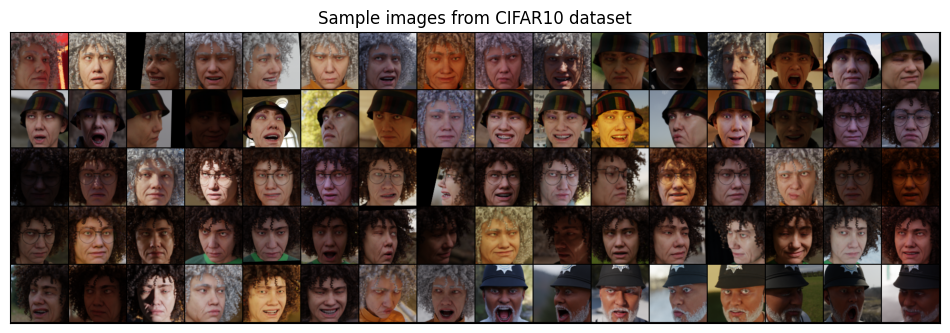

In [10]:
# a temporary data loader without normalization, just to show the images
# Define a transform that only converts images to tensors (no normalization)
tmp_transform = transforms.Compose([
    transforms.ToTensor()
])
tmp_dl = DataLoader(
    torchvision.datasets.ImageFolder(DATA_DIR, transform=tmp_transform),
    batch_size=16 * 5,
    shuffle=False,
)
images, labels = next(iter(tmp_dl))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from CIFAR10 dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

# Model Training

In [11]:
model = resnet18(weights=None, num_classes=10).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4) #Following the training of the starter kit
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

def train(model, train_loader, val_loader, optimizer, loss_fn, epochs, scheduler, device):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f'Epoch {epoch}, Training loss: {running_loss / len(train_loader)}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += loss_fn(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        val_loss /= len(val_loader)
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {100. * correct / len(val_loader.dataset):.2f}%\n')
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        # Log the current learning rate
        current_lr = scheduler.optimizer.param_groups[0]['lr']
        print(f'Current learning rate: {current_lr}\n')
        
        # Save the model if validation loss has decreased
        if val_loss < best_val_loss:
            current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            filename = f'./checkpoints/weights_{MODEL_NAME}_{OPTIM_NAME}_{DATASET_NAME}_{current_time}.pth'
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(best_val_loss, val_loss))
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, filename)
            best_val_loss = val_loss

In [12]:
# GPU
start_time = time.time()

# syncrocnize time with cpu, otherwise only time for oflaoding data to gpu would be measured
torch.mps.synchronize()

train(model, train_loader, val_loader, optimizer, loss_fn, N_EPOCHS, scheduler, DEVICE)

elapsed_time = time.time() - start_time
print( "GPU Time: ", elapsed_time)

Epoch 0, Training loss: 7.167045712471008
Validation Loss: 4696.7569, Accuracy: 10.42%

Current learning rate: 0.1

Validation loss decreased (inf --> 4696.756934). Saving model ...
Epoch 1, Training loss: 2.569900691509247
Validation Loss: 6.9080, Accuracy: 9.72%

Current learning rate: 0.1

Validation loss decreased (4696.756934 --> 6.907998). Saving model ...
GPU Time:  98.24178886413574


# Model loading

In [14]:
# download pre-trained weights
weights_pretrained = torch.load(WEIGHTS_PATH, map_location=DEVICE)

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained['model_state_dict'])
model.to(DEVICE)
model.eval();

# Task Performance

In [15]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Train set accuracy: 9.7%
Test set accuracy: 11.0%
